# 7. 합성곱 신경망 (CNN) 

In [4]:
# 구글 드라이브와 연결
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 7.4 합성곱/풀링 계층 구현하기

### 7.4.1 4차원 배열

CNN에서 계층 사이를 흐르는 데이터는 4차원

In [1]:
# 높이28, 너비28, 채널 1개인 데이터가 10개
import numpy as np

x = np.random.rand(10, 1, 28, 28) # 무작위로 데이터 생성
x.shape

(10, 1, 28, 28)

데이터 인덱스를 통한 접근

In [2]:
print(x[0].shape)
print(x[1].shape)

(1, 28, 28)
(1, 28, 28)


첫번째 데이터의 첫 채널의 공간데이터에 접근

In [3]:
x[0, 0] # 또는 x[0][0]

array([[0.68909796, 0.07564725, 0.21126671, 0.9110407 , 0.70190357,
        0.33108971, 0.91057621, 0.96588812, 0.88609229, 0.49941845,
        0.97963093, 0.00210919, 0.12786759, 0.47361563, 0.12864642,
        0.37186937, 0.35784489, 0.26105214, 0.29318912, 0.17678077,
        0.76647492, 0.28510418, 0.94397371, 0.80340523, 0.38457057,
        0.28374743, 0.89578435, 0.44663903],
       [0.12187937, 0.03540681, 0.98209182, 0.54704694, 0.07177007,
        0.68606148, 0.76272522, 0.35716943, 0.56965682, 0.58996984,
        0.97344658, 0.68451863, 0.3416015 , 0.93203314, 0.76494961,
        0.17520636, 0.1237422 , 0.4392783 , 0.8837733 , 0.18321496,
        0.41903187, 0.1953881 , 0.15909799, 0.85267198, 0.12354214,
        0.68697389, 0.15321648, 0.94276449],
       [0.68370151, 0.68027917, 0.12725199, 0.33772301, 0.02350738,
        0.87590013, 0.52868364, 0.20217779, 0.10500584, 0.23797607,
        0.99387498, 0.65197677, 0.68742643, 0.02225977, 0.4668962 ,
        0.01478423, 0.7732

### 7.4.2 im2col로 데이터 전개하기

- for문 대신 im2col함수 사용하여 간단 구현
- 3차원 데이터에 im2col 적용하면 2차원 행렬로 바뀜

대략적인 im2col의 동작

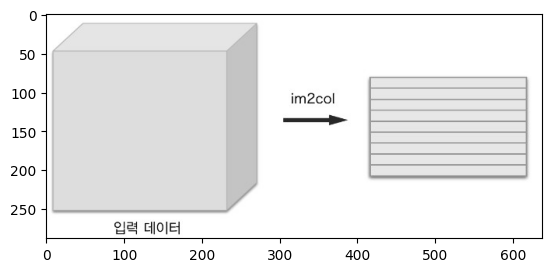

In [5]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/im2col동작.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

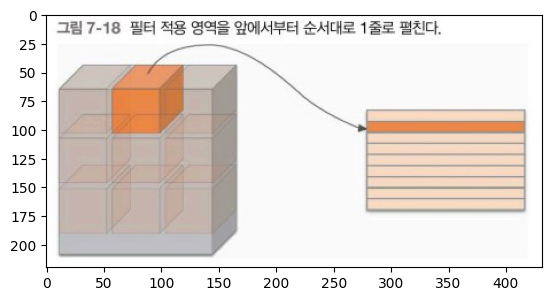

In [6]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/im2col동작2.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 실제 상황에서는 필터 적용 영역이 겹치는 경우가 대부분
- 필터 적용 영역이 겹치게 되면 im2col로 전개한 후의 원소 수가 원래보다 많아짐 (메모리 더 많이 소비)
- 컴퓨터는 큰 행렬을 만들어 계산하는 데 탁월해 효율 높일 수 있음
- im2col 입력 데이터 전개 후 합성곱계층 필터 1열전개하고 행렬곱 계산

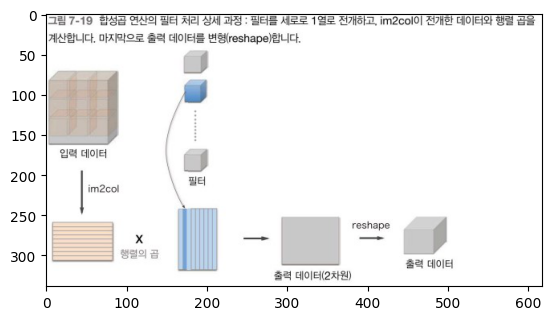

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/im2col동작3.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### 7.4.3 합성곱 계층 구현하기

**im2col의 인터페이스**
- im2col(input_data, filter_h, filter_w, stride=1, pad=0)
    - input_data : (**데이터 수**, **채널 수**, **높이**, **너비**)의 4차원 배열로 이뤄진 입력데이터
    - filter_h : 필터의 높이
    - filter_w : 필터의 너비
    - stride : 스트라이드
    - pad : 패딩

In [9]:
# im2col 사용 구현
 
import sys, os
sys.path.append('/content/drive/My Drive/CUAI_딥러닝/')
from common.util import im2col
 
x1 = np.random.rand(1, 3, 7, 7) # 데이터 수, 채널 수, 높이, 너비
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)
 
x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


- 두 가지 경우 모두 2번째 차원의 원소는 75개
    - 필터의 원소 수와 같음 (채널3, 5*5 데이터)

- 배치크기가 1일 때는 (9, 75) 10일 때는 10배인 (90, 75)

In [10]:
# 합성곱 계층 구현 - Convolution 클래스
 
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad
 
  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
    out_w = int(1 + (W +2*self.pad - FW) / self.stride)
 
    col = im2col(x, FH, FW, self.stride, self.pad) # 입력데이터 전개
    col_W = self.W.reshape(FN, -1).T # 필터 전개
    out = np.dot(col, col_W) + self.b
 
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
 
    return out

- eshape 두 번째 인수 -1로 지정하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 묶어줌
- transpose함수를 이용해 출력데이터를 적절한 형상으로 바꾸어 줌
    - 인덱스를 지정하여 축의 순서 변경

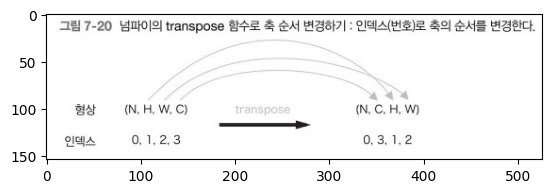

In [14]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/transpose축순서변경.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 역전파에서는 im2col 대신 col2im 함수 사용

### 7.4.4 풀링 계층 구현하기

- 풀링의 경우에는 채널이 독립적이라는 점이 합성곱계층과 다른 점
- 전개 후 최댓값 구하고 적절한 형상으로 바꾸어줌

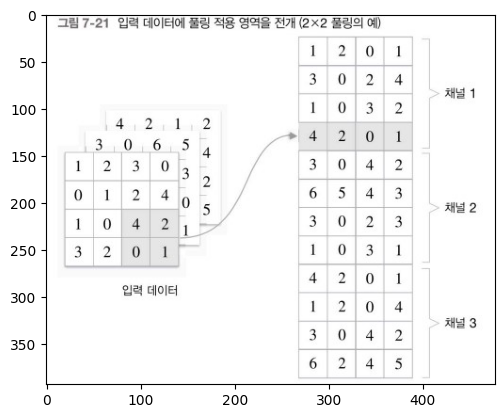

In [16]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/풀링계층구현1.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

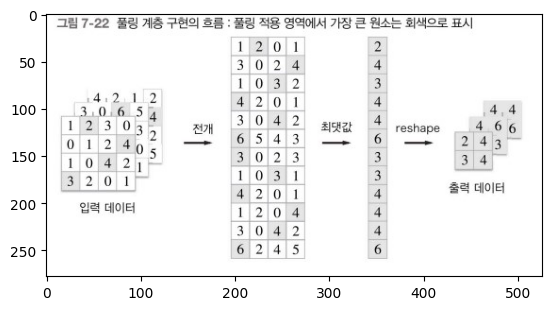

In [17]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/풀링계층구현2.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

In [15]:
# 풀링 계층 구현
 
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad
 
  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)
 
    # 전개 (1)
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h*self.pool_w)
 
    # 최댓값 (2)
    out = np.max(col, axis=1) # 각 행마다 최댓값 도출
 
    # 성형 (3)
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
 
    return out

**< 풀링 계층 구현의 세 단계 >**

1. 입력데이터 전개

2. 행별 최댓값 구함

3. 적절한 모양으로 성형

## 7.5 CNN 구현하기

- conv - relu - pool - affine - relu - affine - softmax 형태

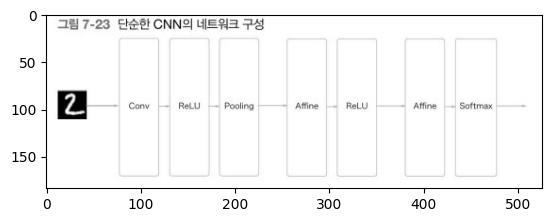

In [18]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/CNN구성.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- **< 초기화(__ init __)에서 받는 파라미터(인수) >**
    - input_dim : 입력 데이터(**채널 수**, **높이**, **너비**)의 차원
    - conv_param : 합성곱 계층의 하이퍼파라미터, 딕셔너리의 키는 다음과 같음
    - filter_num : 필터 수
    - filter_size : 필터 크기
    - stride : 스트라이드
    - pad : 패딩
    - hidden_size : 은닉층(완전연결)의 뉴런 수
    - output_size : 출력층(완전연결)의 뉴런 수
    - weight_init_std : 초기화 때의 가중치 표준편차

- 합성곱계층의 하이퍼파라미터는 딕셔너리 형태로 주어짐

In [22]:
class SimpleConvNet:
    # 초기화 인수로 주어진 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼냄 (나중에 쓰기 쉽도록)
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        # 합성곱 계층의 출력 크기 계산
        conv_output_size = ((input_size - filter_size + 2*filter_pad) / filter_stride) +1 # 24
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2)) # 30*12*12

        # 가중치 매개변수 초기화
        self.params = {} 
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층들 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        # 순서가 있는 딕셔너리인 layers에 계층들을 차례로 추가후 SoftmaxWithLoss 계층은 last_layer라는 별도 변수에 저장함.
        self.last_layer = SoftmaxWithLoss()

        # 추론 수행하는 predict 메서드와 손실 함수의 값을 구하는 loss 메서드
        def predict(self, x):
            for layer in self.layers.values():
                x = layer.forward(x)
            return x
    
        def loss(self, x, t):
            y = self.predict(x)
            return self.last_layer.forward(y, t)
        
        # 오차역전파법으로 기울기를 구하는 구현
        def gradient(self, x, t):
            # 순전파
            self.loss(x, t)
            
            # 역전파
            dout = 1
            dout = self.last_layer.backward(dout)
            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)
                
            # 결과 저장
            grads = {}
            grads['W1'] = self.layers['Conv1'].dW
            grads['b1'] = self.layers['Conv1'].db
            grads['W2'] = self.layers['Affine1'].dW
            grads['b2'] = self.layers['Affine1'].db
            grads['W3'] = self.layers['Affine2'].dW
            grads['b3'] = self.layers['Affine2'].db
            
            return grads

            def accuracy(self, x, t, batch_size=100):
                if t.ndim != 1 : t = np.argmax(t, axis=1)
                
                acc = 0.0
                
                for i in range(int(x.shape[0] / batch_size)):
                    tx = x[i*batch_size:(i+1)*batch_size]
                    tt = t[i*batch_size:(i+1)*batch_size]
                    y = self.predict(tx)
                    y = np.argmax(y, axis=1)
                    acc += np.sum(y == tt) 
                
                return acc / x.shape[0]

In [ ]:
import sys, os
sys.path.append('/content/drive/My Drive/CUAI_딥러닝/')
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer
from common.layers import *
from collections import OrderedDict

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

최종 훈련결과 test accuracy가 96%가 나왔다.

**< 그래프 그리기 >**

In [ ]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 7.6 CNN 시각화하기

### 7.6.1 1번째 층의 가중치 시각화하기

- 1번째 층의 합성곱 계층의 가중치는 (30, 1, 5, 5)
- 채널이 1개라는 것은 필터를 1채널의 회색조 이미지로 시각화 할 수 있다는 뜻

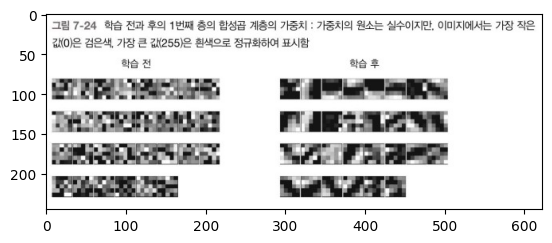

In [25]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/1번째층의가중치시각화.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 왼쪽의 사진이 학습전, 오른쪽 사진이 학습 후의 필터
- 학습 전 필터는 무작위로 초기화되고 있어 흑백의 정도에 규칙성이 없음
- 학습을 마친 필터는 규칙성 있는 이미지
- 규칙성있는 필터는 에지(색상이 바뀐 경계선)와 볼륨(국소적으로 덩어리진 영역) 등 보고 있음
- 합성곱 계층의 필터는 에지나 블롭 등의 원시적인 정보 추출가능, 뒤 계층에 전달

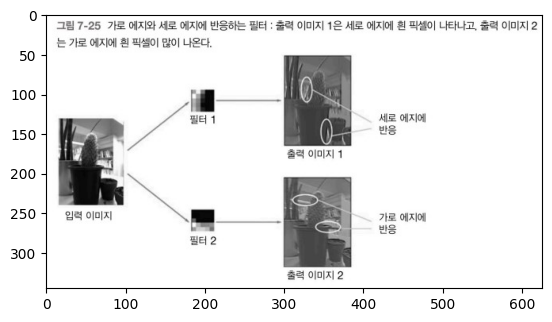

In [26]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/1번째층의가중치시각화2.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### 7.6.2 층 깊이에 따른 추출 정보 변화 

계층이 깊어질수록 추출되는 정보는 더 추상화 됨

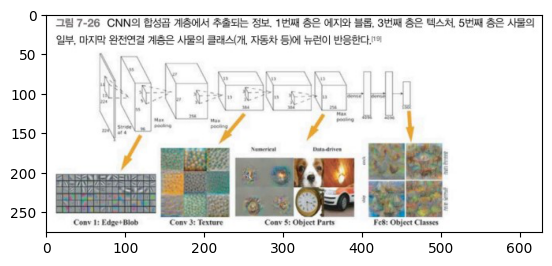

In [27]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/층깊이에따른추출정보변화.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

처음 층은 단순한 에지에 반응하고, 이어 텍스처에 반응하고, 더 복잡한 사물의 일부에 반응하도록 변화

## 7.7 대표적인 CNN

- LeNet과 AlexNet


### 7.7.1 LeNet

- 손글씨 숫자 인식 네트워크 (1998)
- 합성곱 계층과 풀링계층(단순히 원소를 줄이기만 하는 서브샘플링 계층)
- 마지막으로 완전연결계층 거치면서 결과 출력
- LeNet과 현재 CNN 비교
    - 활성화 함수 : LeNet(sigmoid) / 현재(ReLU)
    - 데이터 크기 줄이기 : LeNet(서브샘플링, 중간데이터 크기 줄임) / 현재(MaxPooling)

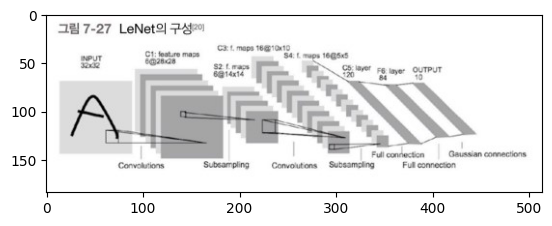

In [31]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/LeNet.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### 7.7.2 AlexNet

**< LeNet과 비교해 바뀐 점 >**
- 활성화 함수로 ReLU 사용
- LRN이라는 국소적 정규화 실시하는 계층 이용
- 드롭아웃 사용
- GPU계산 위해 병렬적인 구조로 설계

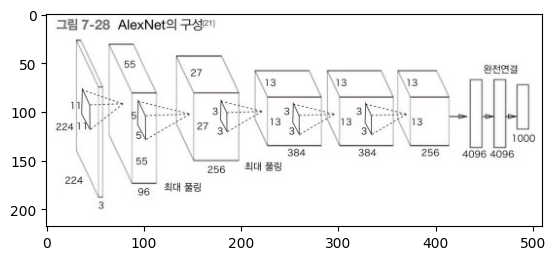

In [30]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/AlexNet.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()